<a href="https://colab.research.google.com/github/jkranyak/project_3/blob/main/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
!pip install tensorflow
!pip install isic-cli
!pip install isic-cli
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.1 MB/s eta 0:00:00


In [3]:
! isic user login

visit the following url in a browser:
https://api.isic-archive.com/oauth/authorize?response_type=code&client_id=RpCzc4hFjv5gOJdM2DM2nBdokOviOh5ne63Tpn7Q&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=nHEnl6TM0TFt2mDL0meoaxeqjxZeXt&code_challenge=zqVvw9P1hvPUVYT5UUDxG9NJrwS2Ct3YEutJEW5E9-g&code_challenge_method=S256
enter the code shown in your browser: W4vmWFPIAacpcYtd6c4pCKeNf7yiNc
Success!


In [4]:
!isic collection list

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ ID  ┃ Name                                          ┃ Public ┃ Pinned ┃ Locked ┃ DOI             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 249 │ BCN20000                                      │ True   │ False  │ False  │ None            │
│ 61  │ Challenge 2016: Test                          │ True   │ True   │ True   │ None            │
│ 74  │ Challenge 2016: Training                      │ True   │ True   │ True   │ None            │
│ 69  │ Challenge 2017: Test                          │ True   │ True   │ True   │ None            │
│ 60  │ Challenge 2017: Training                      │ True   │ True   │ True   │ None            │
│ 71  │ Challenge 2017: Validation                    │ True   │ True   │ True   │ None            │
│ 64  │ Challenge 2018: Task 1-2: Test                │ True   │ True   │ True   │ None    

Step 2: Query the Dataset
Endpoints: Use the API endpoints to query the dataset. Common operations include listing available images, retrieving image metadata, and downloading images.
Filtering: Utilize query parameters to filter the dataset based on your criteria, such as diagnosis, image type, or other metadata.

In [5]:
import requests
import os
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from pathlib import Path
from google.colab import drive
from PIL import Image

In [6]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Comment out if already running

In [7]:
# Specify the current path of kaggle.json file
current_path = '/content/kaggle.json'

# Desired path where the Kaggle API expects the kaggle.json file
desired_path = '/root/.kaggle/kaggle.json'

if os.path.exists(current_path):
    os.makedirs(os.path.dirname(desired_path), exist_ok=True)
    os.rename(current_path, desired_path)

    # Set the file's permissions to avoid a permissions error
    os.chmod(desired_path, 0o600)
else:
    print(f"Error: '{current_path}' does not exist. Please upload the file.")



find the data set on kaggle

Comment out if running and already have downloaded images

In [8]:
!kaggle datasets download -d andrewmvd/isic-2019


100% 9.09G/9.10G [01:11<00:00, 140MB/s]
100% 9.10G/9.10G [01:11<00:00, 136MB/s]


In [9]:
!unzip -q isic-2019.zip


Step 1: Data Preparation and Preprocessing
DICOM Images





Load the metadata

and

Explore the Metadata CSV: Load the metadata.csv files for training, test, and validation sets to understand the structure and types of data available. This step is crucial for preprocessing and feature selection.

In [10]:
# Load the metadata
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

# Display the first few rows of each DataFrame
metadata.head()


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [11]:
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
ground_truth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Load the CSV files
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

image_dir = Path('/content/ISIC_2019_Training_Images')
ground_truth['image_path'] = ground_truth['image'].apply(lambda x: image_dir / f"{x}.jpg")

# Merge the ground_truth with metadata if necessary
full_metadata = pd.merge(ground_truth, metadata, on='image', how='left')  # Adjust 'on' parameter as needed
full_metadata

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,55.0,anterior torso,NaN,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,anterior torso,NaN,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,60.0,upper extremity,NaN,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,upper extremity,NaN,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,80.0,posterior torso,NaN,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007325...,55.0,palms/soles,BCN_0002083,female


In [13]:
# Display the image paths for the first few entries
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Images/ISIC_000000...
1    /content/ISIC_2019_Training_Images/ISIC_000000...
2    /content/ISIC_2019_Training_Images/ISIC_000000...
3    /content/ISIC_2019_Training_Images/ISIC_000000...
4    /content/ISIC_2019_Training_Images/ISIC_000000...
Name: image_path, dtype: object


In [14]:
# Correct the base path in 'image_path' column
correct_base_path = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

full_metadata['image_path'] = full_metadata['image'].apply(lambda x: f"{correct_base_path}/{x}.jpg")

# Verify the correction by printing the first few entries again
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object


In [15]:
full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   MEL                  25331 non-null  float64
 2   NV                   25331 non-null  float64
 3   BCC                  25331 non-null  float64
 4   AK                   25331 non-null  float64
 5   BKL                  25331 non-null  float64
 6   DF                   25331 non-null  float64
 7   VASC                 25331 non-null  float64
 8   SCC                  25331 non-null  float64
 9   UNK                  25331 non-null  float64
 10  image_path           25331 non-null  object 
 11  age_approx           24894 non-null  float64
 12  anatom_site_general  22700 non-null  object 
 13  lesion_id            23247 non-null  object 
 14  sex                  24947 non-null  object 
dtypes: float64(10), object(5)
memory usa

In [16]:
# Fill missing values for 'age_approx' with its median
full_metadata['age_approx'].fillna(full_metadata['age_approx'].median(), inplace=True)

# For categorical data, fill missing values with 'unknown'
full_metadata['anatom_site_general'].fillna('unknown', inplace=True)
full_metadata['sex'].fillna('unknown', inplace=True)


In [17]:
full_metadata = pd.get_dummies(full_metadata, columns=['anatom_site_general', 'sex'])


### Splitting Data into Training, Validation, and Testing Sets

The dataset is initially split into training and temporary sets, with the temporary set reserved for further division into validation and test sets. This method ensures that the model can be trained extensively, validated accurately, and finally tested to evaluate its performance on unseen data.



In [18]:
# Let's separate features and labels first
X = full_metadata.drop(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
y = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']]

# Now, we split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the X_temp and y_temp further into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [19]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(20264, 16) (20264, 9)
(2533, 16) (2533, 9)
(2534, 16) (2534, 9)


### Dual Input Data Generator

The `DualInputGenerator` class is a custom data generator for handling datasets that include both image paths and associated metadata. It is designed to work with Keras/TensorFlow, enabling efficient batch processing which is crucial for training deep learning models on large datasets. Here's a breakdown of its functionality:

- **Initialization (`__init__`)**: This method sets up the generator with all necessary parameters, including image paths, metadata, and labels. It also initializes the batch size, image size, and whether the dataset should be shuffled during training to introduce randomness into the training process.

- **Preprocessing (`preprocess_image`)**: A helper function to read and preprocess images. It converts images to the appropriate size and scale ([224x224] in this case) and normalizes pixel values to the range [0, 1].

- **Length Calculation (`__len__`)**: This method calculates how many batches are in the dataset, which is used by Keras during training to determine the number of steps per epoch.

- **Batch Generation (`__getitem__`)**: This method retrieves a batch of data by processing the images, metadata, and labels. It loads and preprocesses the images specified by the batch indexes, extracts the corresponding metadata, and gathers the labels. The function returns a list containing two arrays (images and metadata) and the batch of labels.

- **Epoch End Handling (`on_epoch_end`)**: If shuffling is enabled, this method shuffles the indexes after each epoch to ensure that the model does not see the same sequence of batches every epoch, helping the model to generalize better.

This structured approach ensures that the model receives properly formatted and preprocessed data for each training step, facilitating effective learning and performance improvement.


Dual Input Generator for creating a mo

In [20]:
class DualInputGenerator(Sequence):
    def __init__(self, image_paths, metadata, labels, batch_size, img_size=(224, 224), shuffle=True):
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def preprocess_image(file_path):
      img = tf.io.read_file(file_path)
      img = tf.image.decode_jpeg(img, channels=3)
      img = tf.image.resize(img, [224, 224])  # Ensuring image size is consistent
      img = img / 255.0  # Normalize to [0, 1]
      return img

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Initialization
        X_images = np.empty((self.batch_size, *self.img_size, 3))
        X_metadata = np.empty((self.batch_size, self.metadata.shape[1]))
        y = np.empty((self.batch_size, self.labels.shape[1]), dtype=int)
        img = preprocess_image(img_path)

        # Generate data
        for i, batch_index in enumerate(batch_indexes):
            # Load and preprocess image
            img_path = os.path.join('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/', self.image_paths[batch_index])
            img = load_img(img_path, target_size=self.img_size)
            X_images[i,] = img_to_array(img) / 255.0

            # Load metadata
            X_metadata[i,] = self.metadata[batch_index]

            # Load label
            y[i,] = self.labels[batch_index]

        return [X_images, X_metadata], y



    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


### Initializing Data Generators for Training, Validation, and Testing

To ensure our model is trained, validated, and tested with data that is efficiently loaded and preprocessed, we initialize three instances of the `DualInputGenerator` class:

- **Training Generator (`train_gen`)**: This generator is configured with training data paths, metadata, and labels. It is responsible for feeding the training data into the model in batches of 32, ensuring that each batch is shuffled to promote model generalization.

- **Validation Generator (`val_gen`)**: Similar to the training generator, but using the validation dataset. This generator provides data for evaluating the model during the training process, allowing us to monitor the model's performance and make adjustments if needed without seeing the test data.

- **Testing Generator (`test_gen`)**: Finally, the testing generator is set up using the test dataset to evaluate the model's performance after training has been completed. This step is crucial for assessing how well the model is likely to perform on unseen real-world data.

Each generator uses the `image_paths`, `metadata`, and `labels` from their respective subsets of the data, ensuring that the model receives all necessary inputs for making predictions during each phase of the training and evaluation process.



In [21]:
# Initialize the training generator
train_gen = DualInputGenerator(
    image_paths=X_train['image_path'].values,
    metadata=X_train.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_train.values,  # Include labels for training set
    batch_size=32
)

# Initialize the validation generator
val_gen = DualInputGenerator(
    image_paths=X_val['image_path'].values,
    metadata=X_val.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_val.values,  # Include labels for validation set
    batch_size=32
)

# Initialize the test generator
test_gen = DualInputGenerator(
    image_paths=X_test['image_path'].values,
    metadata=X_test.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_test.values,  # Include labels for test set
    batch_size=32
)



### Dual Input Neural Network Architecture

The neural network architecture is designed to handle two types of input: images and metadata. Here's a breakdown of the model architecture and the role of each component:

#### Image Input Branch
- **Image Input**: The model starts with an image input layer that accepts images of shape (224, 224, 3).
- **Convolution and Pooling Layers**: Following the input, the model includes two sets of convolutional layers (`Conv2D`) and max pooling layers (`MaxPooling2D`). Each convolutional layer is followed by batch normalization (`BatchNormalization`), which helps to accelerate the training process and stabilize the learning environment by normalizing the activations.
- **Flattening and Dense Layer**: After extracting and pooling features through convolutions, the data is flattened (`Flatten`) and passed through a dense layer with ReLU activation, which is again batch normalized.

#### Metadata Input Branch
- **Metadata Input**: This branch begins with an input for metadata features, shaped dynamically based on the number of metadata features (`num_metadata_features`).
- **Dense Layers and Normalization**: It includes dense layers (`Dense`) with ReLU activation, interspersed with batch normalization to ensure the model learns effectively from the structured data.

#### Combining Branches
- **Concatenation**: The outputs of the image and metadata branches are combined into a single vector (`concatenate`), allowing the model to learn from both image features and metadata simultaneously.
- **Final Dense Layers**: The combined data is then passed through additional dense layers, including a dropout layer (`Dropout`) to prevent overfitting, culminating in a softmax output layer (`Dense`) that classifies the images into one of nine diagnostic categories.

#### Model Compilation
- The model is compiled with the Adam optimizer, using a learning rate of 1e-4. The loss function used is categorical crossentropy, suitable for multi-class classification tasks, and accuracy is used as the metric to evaluate model performance.

This dual-input setup allows the model to leverage both detailed image data and accompanying metadata, aiming to improve diagnostic accuracy compared to using images or metadata alone.


In [22]:
num_metadata_features = X_train.drop(columns=['image', 'image_path', 'lesion_id']).shape[1]
print("Number of metadata features:", num_metadata_features)


Number of metadata features: 13


In [23]:

# Image input branch
image_input = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = BatchNormalization()(x)  # Add batch normalization here
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization here
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_branch = Dense(128, activation='relu')(x)
image_branch = BatchNormalization()(image_branch)  # Add batch normalization here = Dense(128, activation='relu')(x)

# Metadata input branch
metadata_input = Input(shape=(num_metadata_features,), name='metadata_input')
y = Dense(32, activation='relu')(metadata_input)
metadata_branch = BatchNormalization()(y)  # Normalize after the first dense layer
metadata_branch = Dense(64, activation='relu')(metadata_branch)
metadata_branch = BatchNormalization()(metadata_branch)  # Normalize before combining

# Combine the outputs of the two branches
combined = concatenate([image_branch, metadata_branch])
z = Dense(256, activation='relu')(combined)
# adding dropout for regularization
z = Dropout(0.5)(z)
# 9 diagnostic categories
output = Dense(9, activation='softmax')(z)

# Create the model
model = Model(inputs=[image_input, metadata_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


### Model Checkpointing Configuration

The `ModelCheckpoint` callback in TensorFlow Keras is used to save the model at specific intervals or after achieving certain benchmarks during training. This setup is critical for preserving model states and allows for resuming training without losing previous progress. Here's a detailed explanation of the configuration:

- **Checkpoint Path**: Specifies the directory and filename structure for saving the model files. The path includes placeholders for the epoch number (`{epoch:02d}`) and validation accuracy (`{val_accuracy:.2f}`), allowing each file to uniquely represent the state of the model at the end of each epoch.
  
  ```python
  checkpoint_path = "/content/drive/My Drive/your_model_directory/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/My Drive/your_model_directory/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=3, save_best_only=True, mode='max')

In [25]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


### TensorFlow Device Placement and Simple Matrix Multiplication

To gain insight into how TensorFlow allocates computing resources (such as CPU or GPU) for operations, the `set_log_device_placement` flag is enabled. This setting provides detailed logs showing which devices each operation is assigned to, assisting in debugging and optimizing performance.

```python
tf.debugging.set_log_device_placement(True)


In [26]:
tf.debugging.set_log_device_placement(True)

# Test with a simple computation
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# Run on GPU
c = tf.matmul(a, b)

print(c)


tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


### Configuring Callbacks for Model Training

To enhance the training process and ensure optimal model performance, we use a combination of callbacks in TensorFlow. These callbacks are set to monitor the training process and make decisions at the end of each epoch. Here's a breakdown of each callback used:

#### EarlyStopping
- **Purpose**: Prevents overfitting by halting the training if the model's validation loss does not improve for a specified number of consecutive epochs.
- **Configuration**:
  - `monitor='val_loss'`: Watches the validation loss metric for changes.
  - `patience=2`: Allows the training to continue for 2 epochs without improvements in validation loss.
  - `verbose=1`: Enables logging for when the training is stopped early.

#### ModelCheckpoint
- **Purpose**: Saves the model in its current state after each epoch, but only if the model's performance (based on the monitored metric) has improved.
- **Configuration**:
  - `filepath='best_model.h5'`: Specifies the location and filename where the best model version will be saved.
  - `monitor='val_loss'`: Monitors the validation loss for improvements.
  - `save_best_only=True`: Ensures that the model is saved only when its validation loss is at its lowest point seen so far.
  - `verbose=1`: Provides detailed logs when the model is saved.

These callbacks are essential tools for managing long training sessions effectively. They help conserve resources by stopping training when additional epochs would not lead to improvements (`EarlyStopping`) and by ensuring that only the best model version is saved (`ModelCheckpoint`), thus simplifying deployment and further evaluation.

```python
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


In [27]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


### Training the Model

To train the dual-input model, we use the `model.fit` method provided by TensorFlow. This method executes the training cycle across a specified number of epochs, allowing for detailed monitoring and adjustments during the training process. Here's a breakdown of each parameter used in the `model.fit` call:

- **train_gen**: The training data generator, which supplies batches of image and metadata inputs along with the corresponding labels.
- **validation_data**: The validation data generator used to evaluate the model at the end of each epoch, helping monitor its performance on unseen data.
- **epochs**: Sets the total number of training cycles the model will undergo. In this case, the model is set to train for 10 epochs.
- **steps_per_epoch**: Specifies the number of batch steps to complete one epoch. This is set to the total number of batches available in the training generator (`len(train_gen)`), ensuring that each sample is used once per epoch.
- **validation_steps**: Determines the number of batch steps used for validating the model, set to the length of the validation generator.
- **callbacks**: Includes the `EarlyStopping` and `ModelCheckpoint` callbacks configured previously. These enhance the training process by:
  - **EarlyStopping**: Automatically stops training when the validation loss ceases to decrease, preventing overfitting.
  - **ModelCheckpoint**: Saves the best version of the model based on validation loss, ensuring that only the most accurate model is retained.

This configuration ensures that the model is not only trained but also validated effectively, with checkpoints saved automatically and training potentially halted early if no further gains are observed. This approach optimizes both the efficiency and efficacy of the model training process.



In [28]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    # Include callbacks for early stopping and model checkpointing
    callbacks=callbacks
)


Epoch 1/10
633/633 [==============================] - ETA: 0s - loss: 1.7746 - accuracy: 0.5120
Epoch 1: val_loss improved from inf to 1.14278, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


633/633 [==============================] - 279s 438ms/step - loss: 1.7746 - accuracy: 0.5120 - val_loss: 1.1428 - val_accuracy: 0.6021
Epoch 2/10
633/633 [==============================] - ETA: 0s - loss: 1.1711 - accuracy: 0.5897
Epoch 2: val_loss improved from 1.14278 to 1.07034, saving model to best_model.h5
633/633 [==============================] - 275s 434ms/step - loss: 1.1711 - accuracy: 0.5897 - val_loss: 1.0703 - val_accuracy: 0.6218
Epoch 3/10
633/633 [==============================] - ETA: 0s - loss: 1.1230 - accuracy: 0.6027
Epoch 3: val_loss improved from 1.07034 to 1.06091, saving model to best_model.h5
633/633 [==============================] - 275s 434ms/step - loss: 1.1230 - accuracy: 0.6027 - val_loss: 1.0609 - val_accuracy: 0.6226
Epoch 4/10
633/633 [==============================] - ETA: 0s - loss: 1.0795 - accuracy: 0.6181
Epoch 4: val_loss improved from 1.06091 to 1.02852, saving model to best_model.h5
633/633 [==============================] - 277s 437ms/step - 

In [29]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


79/79 [==============================] - 23s 287ms/step - loss: 0.9171 - accuracy: 0.6630
Test Loss: 0.9170709252357483
Test Accuracy: 0.6629746556282043


In [30]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

### Model Summary and Visualization

The `model.summary()` method outputs a detailed architecture of the model, listing each layer, its type, output shape, and number of parameters. This helps in understanding the depth and complexity of the model's structure. Additionally, the `plot_model` function is used to generate a graphical representation of the model, which includes the shapes and names of each layer, offering a clear visual reference of the model's design.

### Generating and Evaluating Predictions

After training, predictions are generated for the test set using the `model.predict` method. This function computes the model's output predictions. The `np.argmax` function is then applied to these predictions to convert the model outputs from probabilities to explicit class predictions. This step is crucial for evaluating the model's classification performance on the test data.

### Collecting True Classes and Generating Confusion Matrix

To evaluate the accuracy of our model's predictions, it is necessary to compare these predicted classes against the true classes from the test set. This comparison is facilitated through the collection of true class labels directly from the test generator. Subsequently, a confusion matrix is generated using the `confusion_matrix` function. This matrix is a powerful tool for visualizing the performance of a classification model, showing the actual versus predicted classifications, which helps in identifying how well the model is performing with respect to different classes. The `seaborn.heatmap` function is then used to plot the confusion matrix, providing a color-coded visualization of the results, which makes it easier to interpret the model's accuracy and misclassifications.



In [31]:
model.summary()

# Generate a plot of the model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d[0][0]']   

In [33]:
# Generate predictions using the test generator
predictions = model.predict(test_gen, steps=len(test_gen))

# Obtain the predicted classes by taking the argmax of the predictions array
predicted_classes = np.argmax(predictions, axis=1)

# Since your test_gen should also be outputting the true classes in the same order as the predictions:
# We need to collect all true classes from the generator (in the same order)
true_classes = []
for _, labels in test_gen:
    true_classes.extend(np.argmax(labels, axis=1))
    if len(true_classes) >= len(predictions):
        break  # Stop once we have all the labels we need

# Generate the confusion matrix
cm = confusion_matrix(true_classes[:len(predictions)], predicted_classes)

print(cm)


79/79 [==============================] - 23s 284ms/step
[[ 55 268  93   1  11   0   1   1]
 [149 791 291   4  41   0   8   0]
 [ 50 203  80   0  14   0   1   1]
 [ 10  64  17   1   4   0   1   0]
 [ 33 156  62   0   3   0   4   1]
 [  2  15   4   0   0   0   0   0]
 [  3  21   6   0   1   0   0   0]
 [ 11  36   8   0   2   0   0   0]]


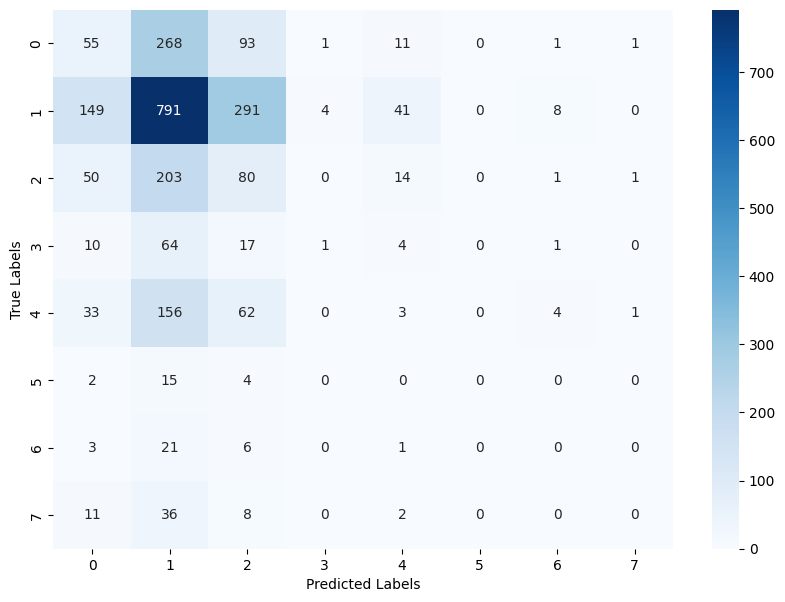

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

###Summary of Confusin Matrix
Classes 3, 4, 5, 6, and 7 show a particular need for augmentation due to low true positives and high confusion with other classes. Class 0 also needs attention due to being frequently confused with other high-incidence classes. These focused augmentations aim to enhance the model's ability to distinguish these classes more clearly, which should improve overall accuracy and reduce misclassifications.

66.46% is ok, but lets do some fine tuning... and save it!

### Model Evaluation and Misclassification Analysis

The process starts by loading a previously trained model from disk using `load_model`. This model is then used to evaluate its performance on unseen data provided by a test generator. The evaluation consists of several steps:

#### Loading the Model
The model is loaded from a saved file, ensuring that the most effective version of the model, as determined by prior validations, is used for evaluations.

#### Fetching Predictions and Labels
A custom function `get_predictions_and_labels` is employed to iterate over the test generator. This function fetches batches of data (both images and metadata) and corresponding labels, then uses the model to predict each batch. Predictions and true labels are accumulated from all batches, allowing for comprehensive evaluation.

#### Calculating Confusion Matrix and Classification Report
Once predictions are gathered, they are converted from softmax probabilities to class predictions using `np.argmax`. With predictions and true labels in hand, a confusion matrix is generated to visually assess the model's performance across different classes. This matrix highlights which classes are being confused with others, providing insight into potential biases or weaknesses in the model.

A classification report is also generated to provide key metrics for each class, such as precision, recall, and F1-score. This report helps in understanding the model's accuracy and identifying classes that might require more focus during further model training.

#### Visualizing Misclassified Examples
Finally, the script identifies and displays a set of misclassified images along with their true and predicted labels. This visualization is crucial for diagnosing what might be causing the errors, potentially guiding further data collection, augmentation strategies, or model adjustments.

Each of these steps plays a vital role in evaluating the model's real-world applicability and robustness, ensuring that the model not only performs well statistically but also meets practical expectations.


1/1 [==============================] - 0s 102ms/step
Confusion Matrix:
 [[ 175  191   34    5   25    0    0    0]
 [  42 1197   23    1   20    0    1    0]
 [  27   85  215    5   15    0    2    0]
 [  12   15   37   17   16    0    0    0]
 [  48   94   35    6   76    0    0    0]
 [   0   12    9    0    0    0    0    0]
 [   0   10   10    0    0    0   11    0]
 [   5    7   31    6    8    0    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.41      0.47       430
           1       0.74      0.93      0.83      1284
           2       0.55      0.62      0.58       349
           3       0.42      0.18      0.25        97
           4       0.47      0.29      0.36       259
           5       0.00      0.00      0.00        21
           6       0.79      0.35      0.49        31
           7       0.00      0.00      0.00        57

    accuracy                           0.67      2528
   macro avg    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


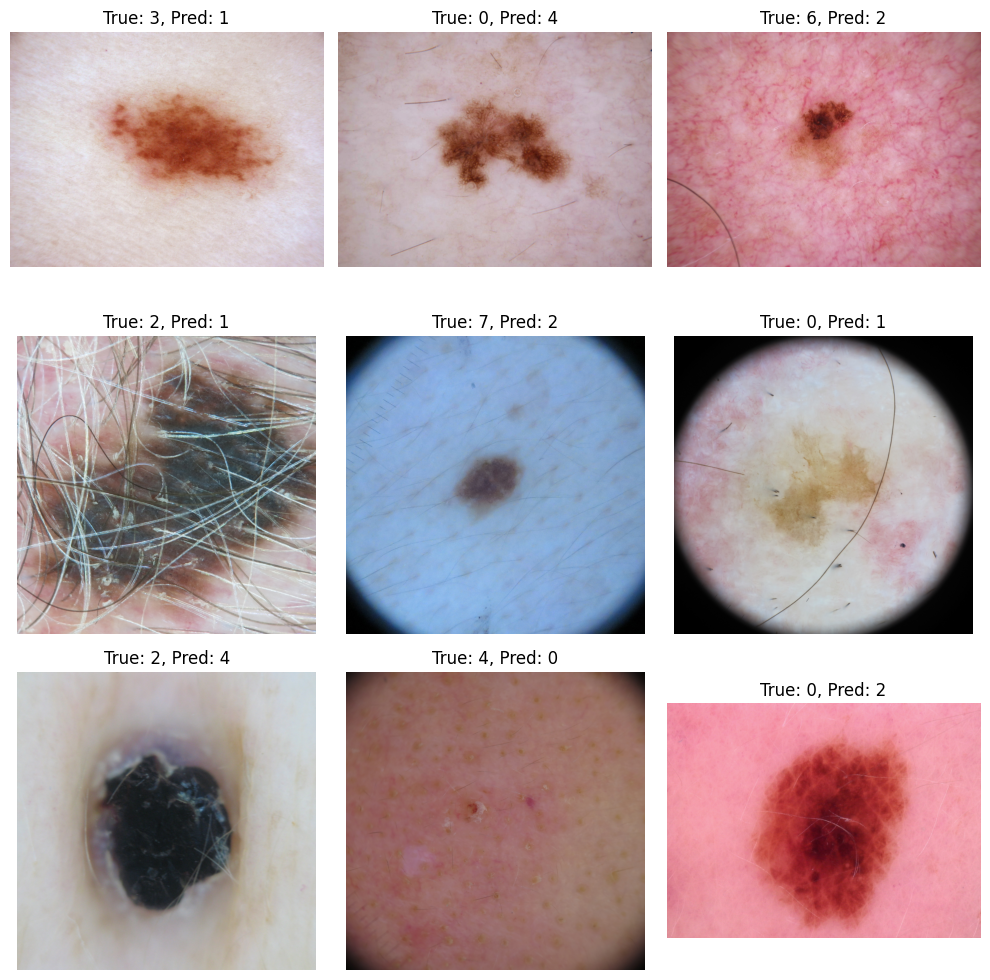

In [35]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the model
model = load_model('/content/best_model.h5')

# Function to fetch data and labels from the generator
def get_predictions_and_labels(generator):
    predictions = []
    true_labels = []
    for _ in range(len(generator)):
        # Getting the next batch of data
        (images, metadata), labels = generator.__getitem__(_)
        # Predict this batch
        batch_predictions = model.predict([images, metadata])
        # Store predictions and labels
        predictions.append(batch_predictions)
        true_labels.append(labels)

    # Concatenate all batches
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)

    return predictions, true_labels

# Using the test generator to get predictions and labels
predictions, true_labels = get_predictions_and_labels(test_gen)

# Convert softmax probabilities to class predictions
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:\n', cm)

# Generate a classification report
print('\nClassification Report:\n', classification_report(true_classes, predicted_classes))

# Identify misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]
print(f'Total misclassified samples: {len(misclassified_indices)}')

# Assuming you want to visualize some misclassified images:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(misclassified_indices):
        idx = misclassified_indices[i]
        img = test_gen.image_paths[idx]  # Assuming image paths are stored here
        true_label, pred_label = true_classes[idx], predicted_classes[idx]
        ax.imshow(plt.imread(img))  # Reading the image from path
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        ax.axis('off')
plt.tight_layout()
plt.show()


Lets just run it a few more times and see if it can get any better before it gets any worse...

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from datetime import datetime

# Load the previously saved model
model = load_model('/content/best_model.h5')

# Define your callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ModelCheckpoint(filepath='/content/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Path where the checkpoint will be saved
model_dir = '/content/drive/My Drive/Colab Models'
# Generate a unique identifier based on the current date and time
unique_identifier = datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_filepath = os.path.join(model_dir, f'best_model_{unique_identifier}.h5')

# model_filename = 'best_model.h5'
# # Check if the best model exists and load it
# if os.path.exists(model_filename):
#     model = load_model(model_filename)
#     print("Loaded the best model from the last training session.")
# # Continue with defining callbacks without overwriting the best model inadvertently
# # callbacks = [
# #    ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True, verbose=1)]


# Continue training with generators and include callbacks
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    # Adjust the total epochs as needed
    epochs=20,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=callbacks
)


Epoch 1/20
519/633 [=======================>......] - ETA: 45s - loss: 0.9261 - accuracy: 0.6708

### Evaluation of Classifier Performance Using ROC Curves

To evaluate the performance of the classifier on a per-class basis, the Receiver Operating Characteristic (ROC) curves and the Area Under the Curve (AUC) are computed. These metrics are crucial for assessing the model's ability to distinguish between classes. Here's a breakdown of the steps involved in this evaluation:

#### Preparing Labels and Predictions
Firstly, the true labels are converted to a 1-dimensional array if they are not already in this format, ensuring they can be directly compared with the predicted probabilities. Predictions are checked to ensure they contain a probability for each class.

#### Computing ROC Curves and AUC Values
For each class, the ROC curve is calculated by:
- Isolating the prediction probabilities for that class.
- Creating a binary outcome array for the class, where the class of interest is labeled `1` and all others `0`.
- Using the `roc_curve` function from `sklearn.metrics` to compute the true positive rate (TPR) and false positive rate (FPR) at various threshold settings.
- Calculating the AUC value to quantify the overall ability of the model to discriminate between positive and negative classes for each specific class.

#### Plotting the ROC Curves
Each class's ROC curve is plotted with a unique color, and the AUC score is displayed in the legend to provide a visual and numerical representation of classifier performance. The diagonal line represents a random classifier's performance for comparison.

- **X-axis**: False Positive Rate (FPR) — represents the proportion of negative data points that are mistakenly considered positive.
- **Y-axis**: True Positive Rate (TPR) — represents the proportion of actual positives correctly identified.

The area under each curve (AUC) provides a single measure of overall performance regardless of the classification threshold. The closer the AUC is to 1, the better the model is at predicting positive classes as positive and negative classes as negative. Values closer to 0.5 suggest no discriminative ability, equivalent to random guessing.

This detailed analysis helps in identifying which classes the model performs well on and which ones might require further tuning, potentially guiding further data augmentation, additional training, or algorithm adjustments.


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure that true_labels is a 1D array of class indices
if len(true_labels.shape) > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Ensure predictions are probabilities
if predictions.shape[1] == len(np.unique(true_labels)):
    print("Predictions appear to be properly formatted.")

n_classes = len(np.unique(true_labels))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Isolate the probabilities for the current class
    class_probs = predictions[:, i]
    # Create a binary outcome for this class
    class_true = (true_labels == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(class_true, class_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, n_classes))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by class')
plt.legend(loc="lower right")
plt.show()



In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


User Interface (UI)
A simple web-based UI allows users to upload lesion images, input relevant metadata, and receive a prediction. We will use Gradio as learned in class for this model.

In [ ]:
! pip install gradio --upgrade
! pip install gradio ai

In [ ]:
! pip install openai

In [ ]:
import gradio as gr
from gradio import Image, Number, Radio, Dropdown

import numpy as np
from PIL import Image
import os
from PIL import Image as PILImage

import tensorflow as tf
from tensorflow import keras

import openai

In [ ]:
with open('/content/drive/MyDrive/API AI OPEN.txt', 'r') as file:
    openai_api_key = file.read().strip()

In [ ]:
openai.api_key = openai_api_key

### Model Loading and Prediction Testing

#### Loading the Pre-trained Model
The script begins by loading a pre-trained model from a specified path. This model is essential for predicting the type of skin lesions based on image data and associated metadata.

#### Model Architecture Overview
Once the model is loaded, `model.summary()` is called to print the architecture of the model. This summary provides insight into the model's layers, their shapes, and parameters, which is crucial for understanding how the model processes input data.

#### Dummy Prediction
To ensure the model is functioning correctly, a dummy input array is created using random data, shaped appropriately for the model's expected input (in this case, 224x224x3 for image data). This array is then used to make a prediction, testing the model's readiness for actual data.

### Image Preprocessing and Prediction Explanation Function

#### Image Preprocessing
The script defines a function `preprocess_image` that takes an uploaded image file, resizes it to fit the model's input requirements, normalizes the pixel values, and expands its dimensions to include a batch size for model input compatibility.

#### Prediction and Explanation Generation
Another function, `predict_and_explain`, is designed to handle the end-to-end process from image and metadata input through to generating a human-readable explanation of the prediction. This function:
- Preprocesses the input image for model prediction.
- Uses the model to predict the lesion type based on the image.
- Maps the prediction to a readable class description.
- Optionally, uses GPT-3 to generate a detailed explanation of the diagnosis, integrating the lesion's metadata for a comprehensive overview.

### User Interface for Skin Lesion Classification

#### Interface Setup
The script utilizes `gr.Interface` from the Gradio library to create an interactive web interface. This interface allows users to upload images of skin lesions and input relevant metadata (age, sex, and anatomical site).

#### Interface Launch
Finally, the interface is launched, making it accessible via a web browser. Users can interact with the model, upload images, input metadata, and receive predictions along with explanations right in the interface.

### Usage and Disclaimer
The interface includes a title and a detailed description, advising users on how to use the tool and noting that predictions should not replace professional medical advice. This ensures users understand the context and limitations of the model predictions.

This comprehensive setup allows for an accessible and user-friendly way to leverage advanced machine learning models for educational and preliminary diagnostic support in dermatology.


In [ ]:
diagnosis_descriptions = {
    'MEL': 'Melanoma: a serious form of skin cancer that begins in cells known as melanocytes.',
    'NV': 'Melanocytic nevus: a common type of skin growth that often appears as a small, dark brown spot.',
    'BCC': 'Basal cell carcinoma: a type of skin cancer that most often develops on areas exposed to the sun.',
    'AK': 'Actinic keratosis: a rough, scaly patch on the skin caused by years of sun exposure.',
    'BKL': 'Benign keratosis: a non-cancerous skin condition that appears as a waxy brown, black, or tan growth.',
    'DF': 'Dermatofibroma: a common growth on the skin, usually found on the lower legs, that can be pink, red, or brown.',
    'VASC': 'Vascular lesion: a type of abnormal growth or mark on the skin that is made up of blood vessels.',
    'SCC': 'Squamous cell carcinoma: a common form of skin cancer that develops in the squamous cells.',
    'UNK': 'None of the others: the lesion does not fit into any of the other categories.'
}

disclaimer = """
**Disclaimer:** This tool is intended for educational and entertainment purposes only and should not be used as a substitute for professional medical advice, diagnosis, or treatment. Always seek the advice of your physician or other qualified health provider with any questions you may have regarding a medical condition. Remember, this AI is not a medical doctor, and its assessments are not diagnoses. Use this tool responsibly and always consult with a healthcare professional for any medical concerns.
"""


In [ ]:
# Load the model
model_path = '/content/best_model.h5'
model = keras.models.load_model(model_path)

# Print model summary
model.summary()

# Create a dummy input array and make a prediction
test_input = np.random.random((1, 224, 224, 3))
test_prediction = model.predict(test_input)
print(test_prediction)

def preprocess_image(uploaded_image):
    img = PILImage.open(uploaded_image).resize((224, 224))  # Ensure uploaded_image is a path or file-like object
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_and_explain(image, age, sex, location):
    preprocessed_image = preprocess_image(image)
    # Replace the following line with your model prediction logic
    prediction = model.predict(preprocessed_image)[0]
    predicted_class_index = np.argmax(prediction)
    predicted_class_key = list(diagnosis_descriptions.keys())[predicted_class_index]
    description = diagnosis_descriptions[predicted_class_key]

    metadata_sentence = f"A {age}-year-old {sex} has a lesion located at {location}."

    try:
        response = openai.Completion.create(
            engine="text-davinci-003",
            prompt=f"{metadata_sentence} It was diagnosed as {predicted_class_key} ({description}). Provide an explanation.",
            temperature=0.7,
            max_tokens=100
        )
        additional_info = response.choices[0].text.strip()
    except Exception as e:
        additional_info = "Could not fetch additional information from GPT-3."

    full_explanation = f"Diagnosis: {predicted_class_key} - {description}.\n\nAdditional info: {additional_info}"
    return full_explanation

# Create the interface
iface = gr.Interface(
    fn=predict_and_explain,
    inputs=[
        Image(),  # Removed the shape parameter
        Number(label="Age"),
        Radio(choices=['Male', 'Female', 'Other'], label="Sex"),
        Dropdown(choices=['Head/Neck', 'Upper Extremity', 'Lower Extremity', 'Torso', 'Palms/Soles', 'Oral/Genital', 'Other'], label="Anatomical Site")
    ],
    outputs="text",
    title="Skin Lesion Classifier",
    description="Upload an image of a skin lesion and enter metadata to predict its type. Read the disclaimer below before proceeding."
)

# Launch the interface
iface.launch()
